# Introduction

This notebook was created by Cade Schkerke for a SQLAlchemy homework assignment.

In this notebook, weather data for Honolulu, Hawaii is used to analyze temperature and precipitation between the dates of 08-23-2016 to 08-23-2017. By examining the climate for this range, we're able to predict (approximately) future climate and weather conditions. 

# Observations

Based on the data analyzed, Honolulu receives the most rain in September, February, and April, with all months receiving at least 5 inches of rain. 

The month with the most rain overall, was September with nearly 7 inches of rain.

The temperature observed indicates that it's usually between 70-80 degrees(F) throughout the year. 

In [1]:
# Importing Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine,reflect=True)

In [10]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [40]:
# Using inspect to view the columns in the tables to get a better understanding and make later calls easier
inspector = inspect(engine)
columns_ms = inspector.get_columns('measurement')
columns_st = inspector.get_columns('station')

In [41]:
for column in columns_ms:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [42]:
for column in columns_st:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

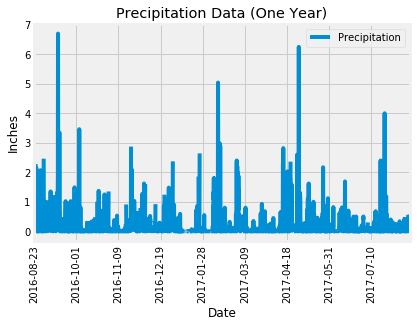

In [90]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()

# Redefining most_recent from result to string in order to switch date format
most_recent = most_recent[0]

# Switching date format
most_recent = dt.datetime.strptime(most_recent, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
year_ago = most_recent - dt.timedelta(days=366) # setting days=365 will query to 2016-08-24 rather than 2016-08-23

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.prcp, measurement.date).filter(measurement.date >= year_ago).all()

# Testing to verify first and last date of the year were retrieved correctly
precip_data[0]
precip_data[-1]

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data, columns=['Precipitation', 'Date'])
precip_df.set_index('Date', inplace=True)

# Sort the dataframe by date
sorted_precip_df = precip_df.sort_values(by='Date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
sorted_precip_df.plot(title="Precipitation Data (One Year)")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.savefig("Images/Precipitation.png", bbox_inches='tight')
plt.show()

In [82]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [114]:
# Design a query to show how many stations are available in this dataset
avail_stations = session.query(station.station).count()
print(f"There are {avail_stations} available stations in this dataset.")

There are 9 available stations in this dataset.


In [122]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station))\
                         .group_by(measurement.station)\
                         .order_by(func.count(measurement.station).desc())\
                         .all()
active_stations_df = pd.DataFrame(active_stations, columns=['Station', 'Count'])
active_stations_df

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [137]:
# Which station has the highest number of observations
most_ob = active_stations_df['Station'].iloc[0]
print(f"The station with the highest number of observations is {most_ob}.")

The station with the highest number of observations is USC00519281.


In [151]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
stat_temps = session.query(func.min(measurement.tobs),\
                           func.max(measurement.tobs),\
                           func.avg(measurement.tobs))\
                           .filter(measurement.station == most_ob).all()
print(f"Station {most_ob}'s lowest temperature was {stat_temps[0][0]}")
print(f"Highest temperature was {stat_temps[0][1]}")
print(f"And the station averaged a temperature of {round(stat_temps[0][2],2)}.")

Station USC00519281's lowest temperature was 54.0
Highest temperature was 85.0
And the station averaged a temperature of 71.66.


In [157]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
most_ob_data = session.query(measurement.tobs)\
                      .filter(measurement.date >= year_ago)\
                      .filter(measurement.station == most_ob)\
                      .all()
most_ob_df = pd.DataFrame(most_ob_data)
most_ob_df

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


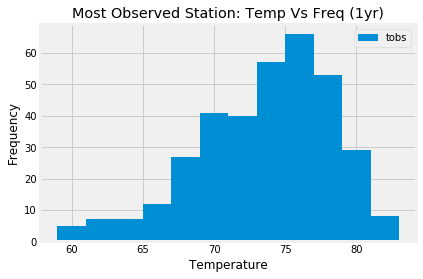

In [159]:
#  and plot the results as a histogram
most_ob_df.plot.hist(bins=12, title='Most Observed Station: Temp Vs Freq (1yr)')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.savefig("Images/station-histogram.png", bbox_inches='tight')
plt.show()